In [1]:
## General initialization

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
import numpy as np
seed = 42
if seed is not None:
   np.random.seed(seed)

# Read Data

In [2]:
## Reading input Learning Data

#configuration path Data
path_train_data = "./data/processed/train.json"

#Read Data
import numpy as np
import pandas as pd
train_data = pd.read_json(path_train_data)
print("Size of train data:{}".format(len(train_data)))

#Size of images
size_image = len(train_data.iloc[0]['band_1'])
print("size of image in band_1: {}".format(size_image))
width_image = int(np.sqrt(size_image))
print("Shape of image: {}x{}".format(width_image, width_image))

#Percentage Ships/icebergs
idx_iceberg_td = train_data["is_iceberg"] == 1
idx_ship_td = train_data["is_iceberg"] == 0
num_iceberg_in_train_data = train_data[idx_iceberg_td].shape[0]
print("In train data: percentage of iceberg: {}%".format(100 * num_iceberg_in_train_data / train_data.shape[0]))


Size of train data:1604
size of image in band_1: 5625
Shape of image: 75x75
In train data: percentage of iceberg: 46.94513715710723%


In [3]:
## Reading input Test Competition Kaggle Data

#configuration path Data
path_test_data = "./data/processed/test.json"

#Read Data
import numpy as np
import pandas as pd
test_data = pd.read_json(path_test_data)
print("size of test data:{}".format(len(test_data)))


size of test data:8424


In [4]:
from IPython.display import display # Allows the use of display() for DataFrames
display(train_data.head())


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [5]:
## Pre processing of inc_angle value

#Handle non numeric values, and Nan value
idx_inc_angle_nan_td = train_data["inc_angle"] == 'na'
print("Number of missing value for inc angle in training: {}".format(train_data[idx_inc_angle_nan_td].shape[0]))

#convert to numeric value
train_data['inc_angle'] = pd.to_numeric(train_data['inc_angle'], errors='coerce')
print(train_data.dtypes)




Number of missing value for inc angle in training: 133
band_1         object
band_2         object
id             object
inc_angle     float64
is_iceberg      int64
dtype: object


# Data Exploration visual

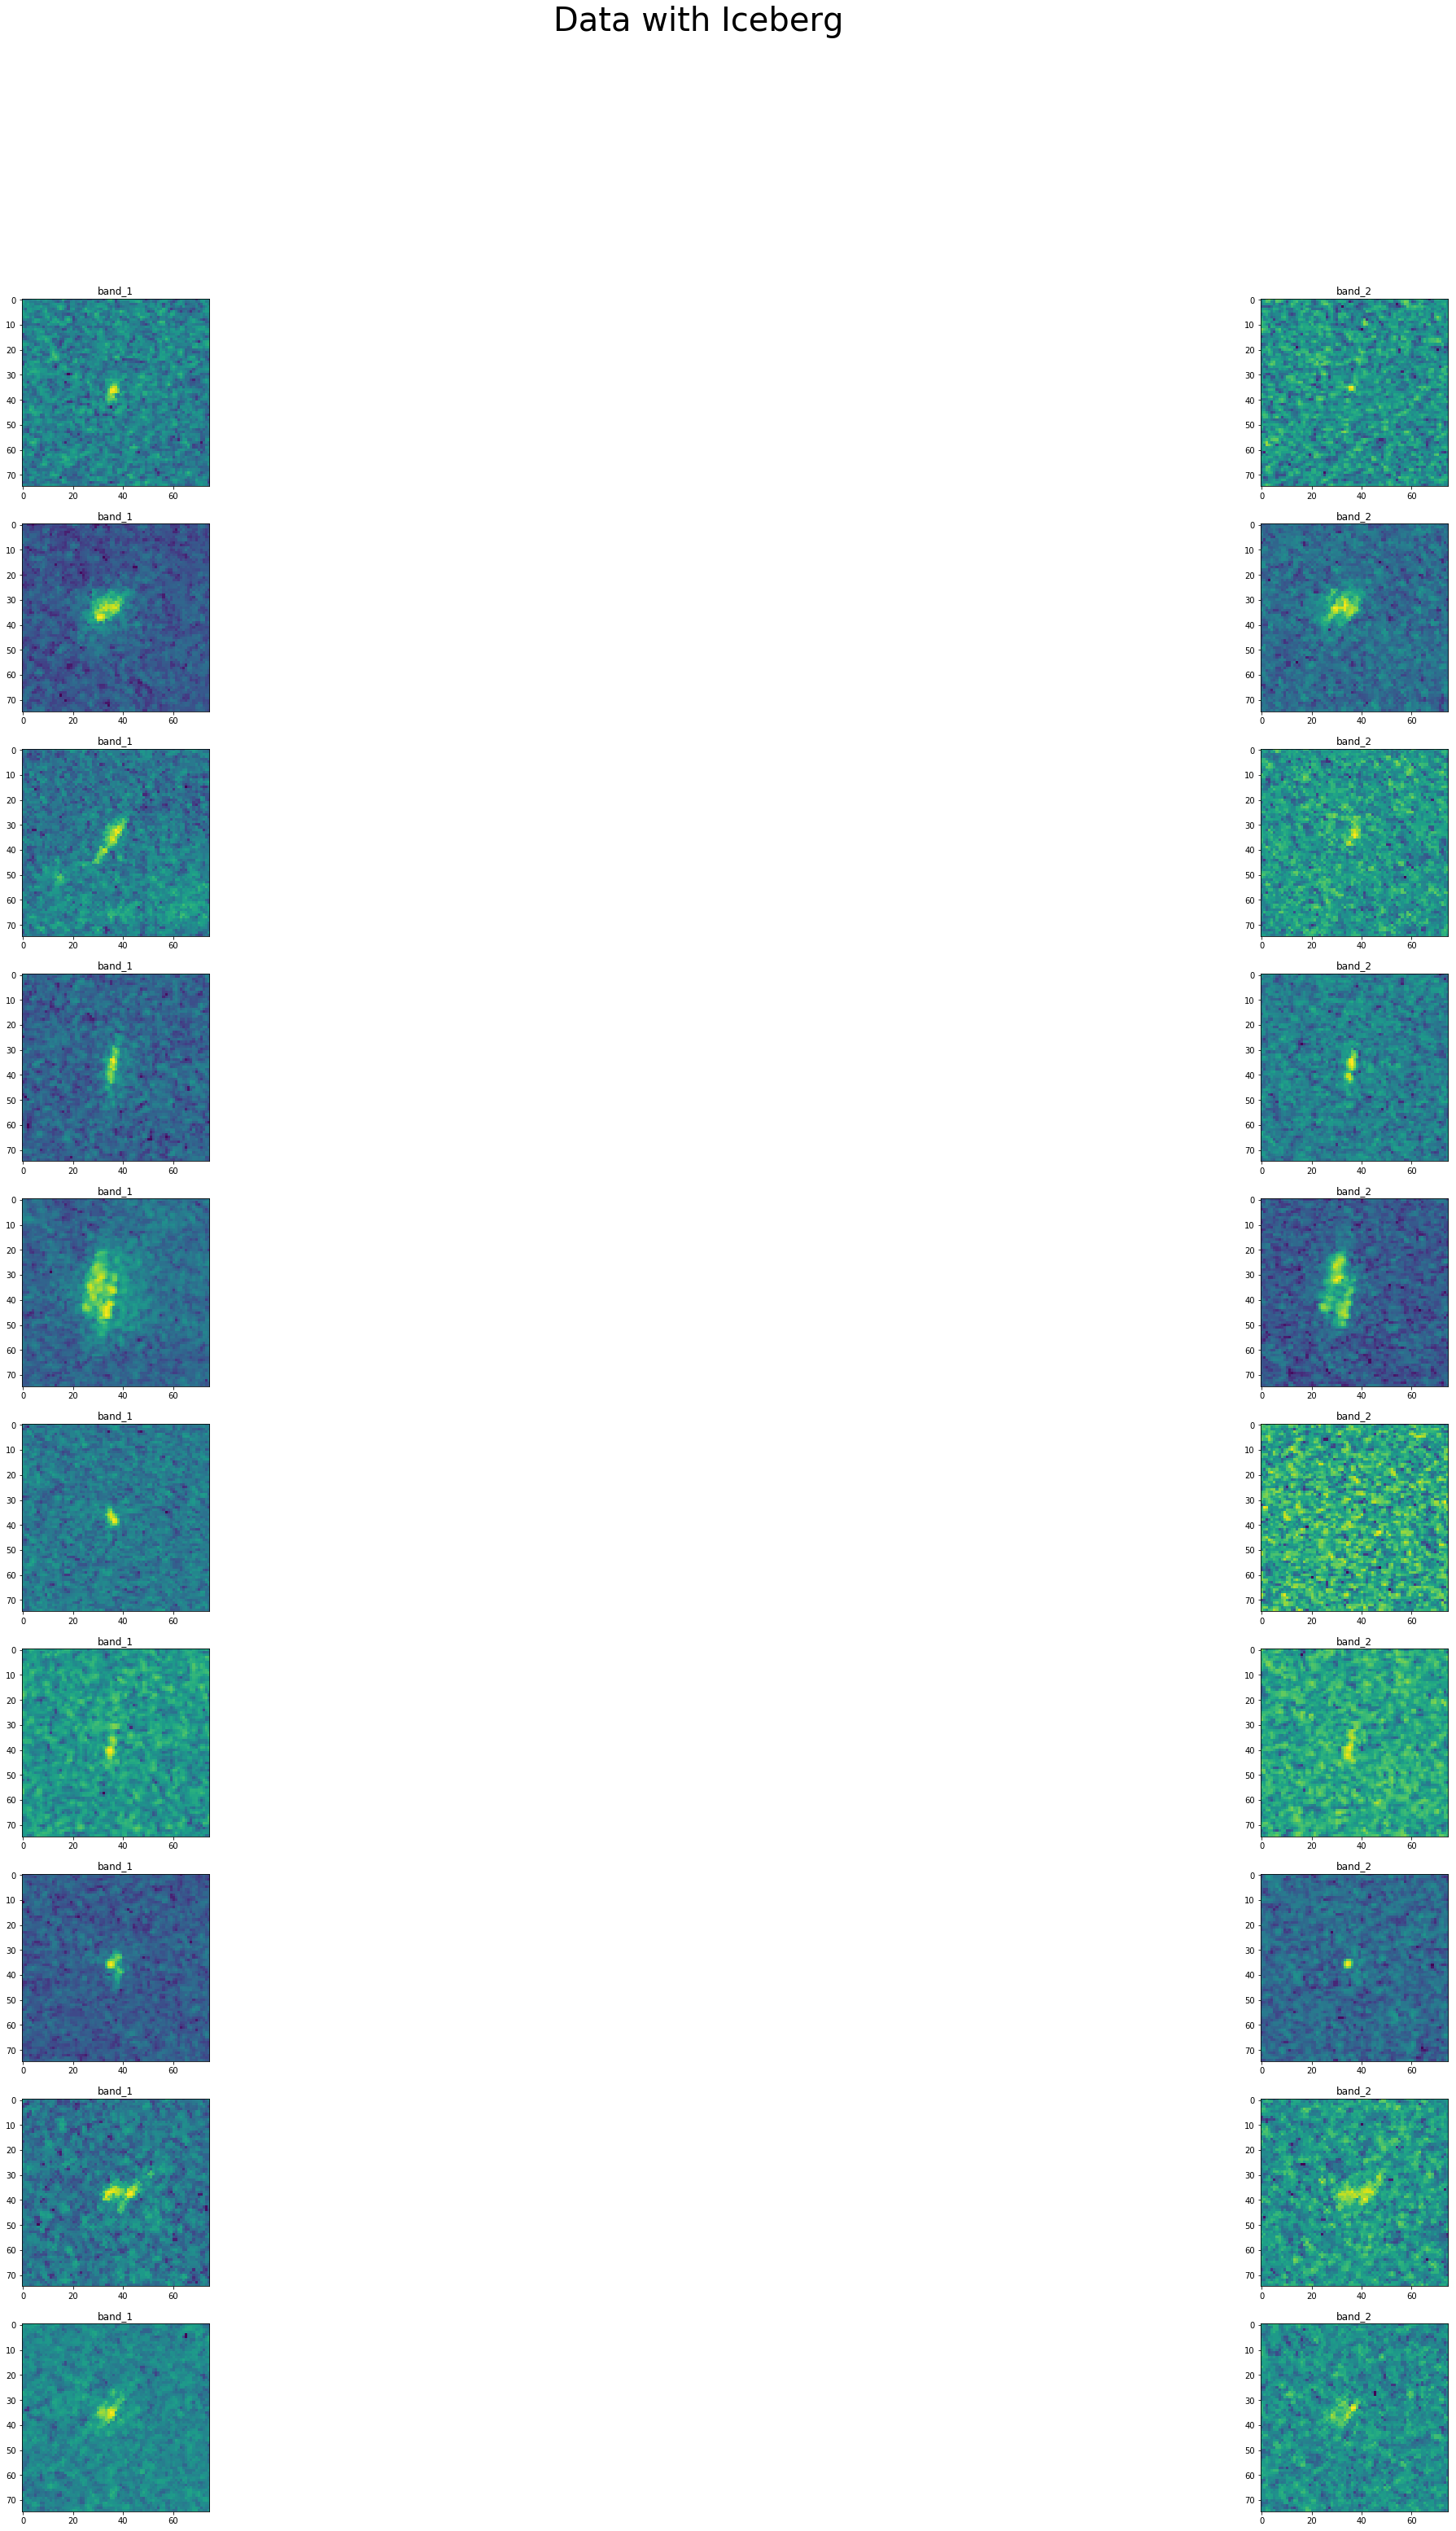

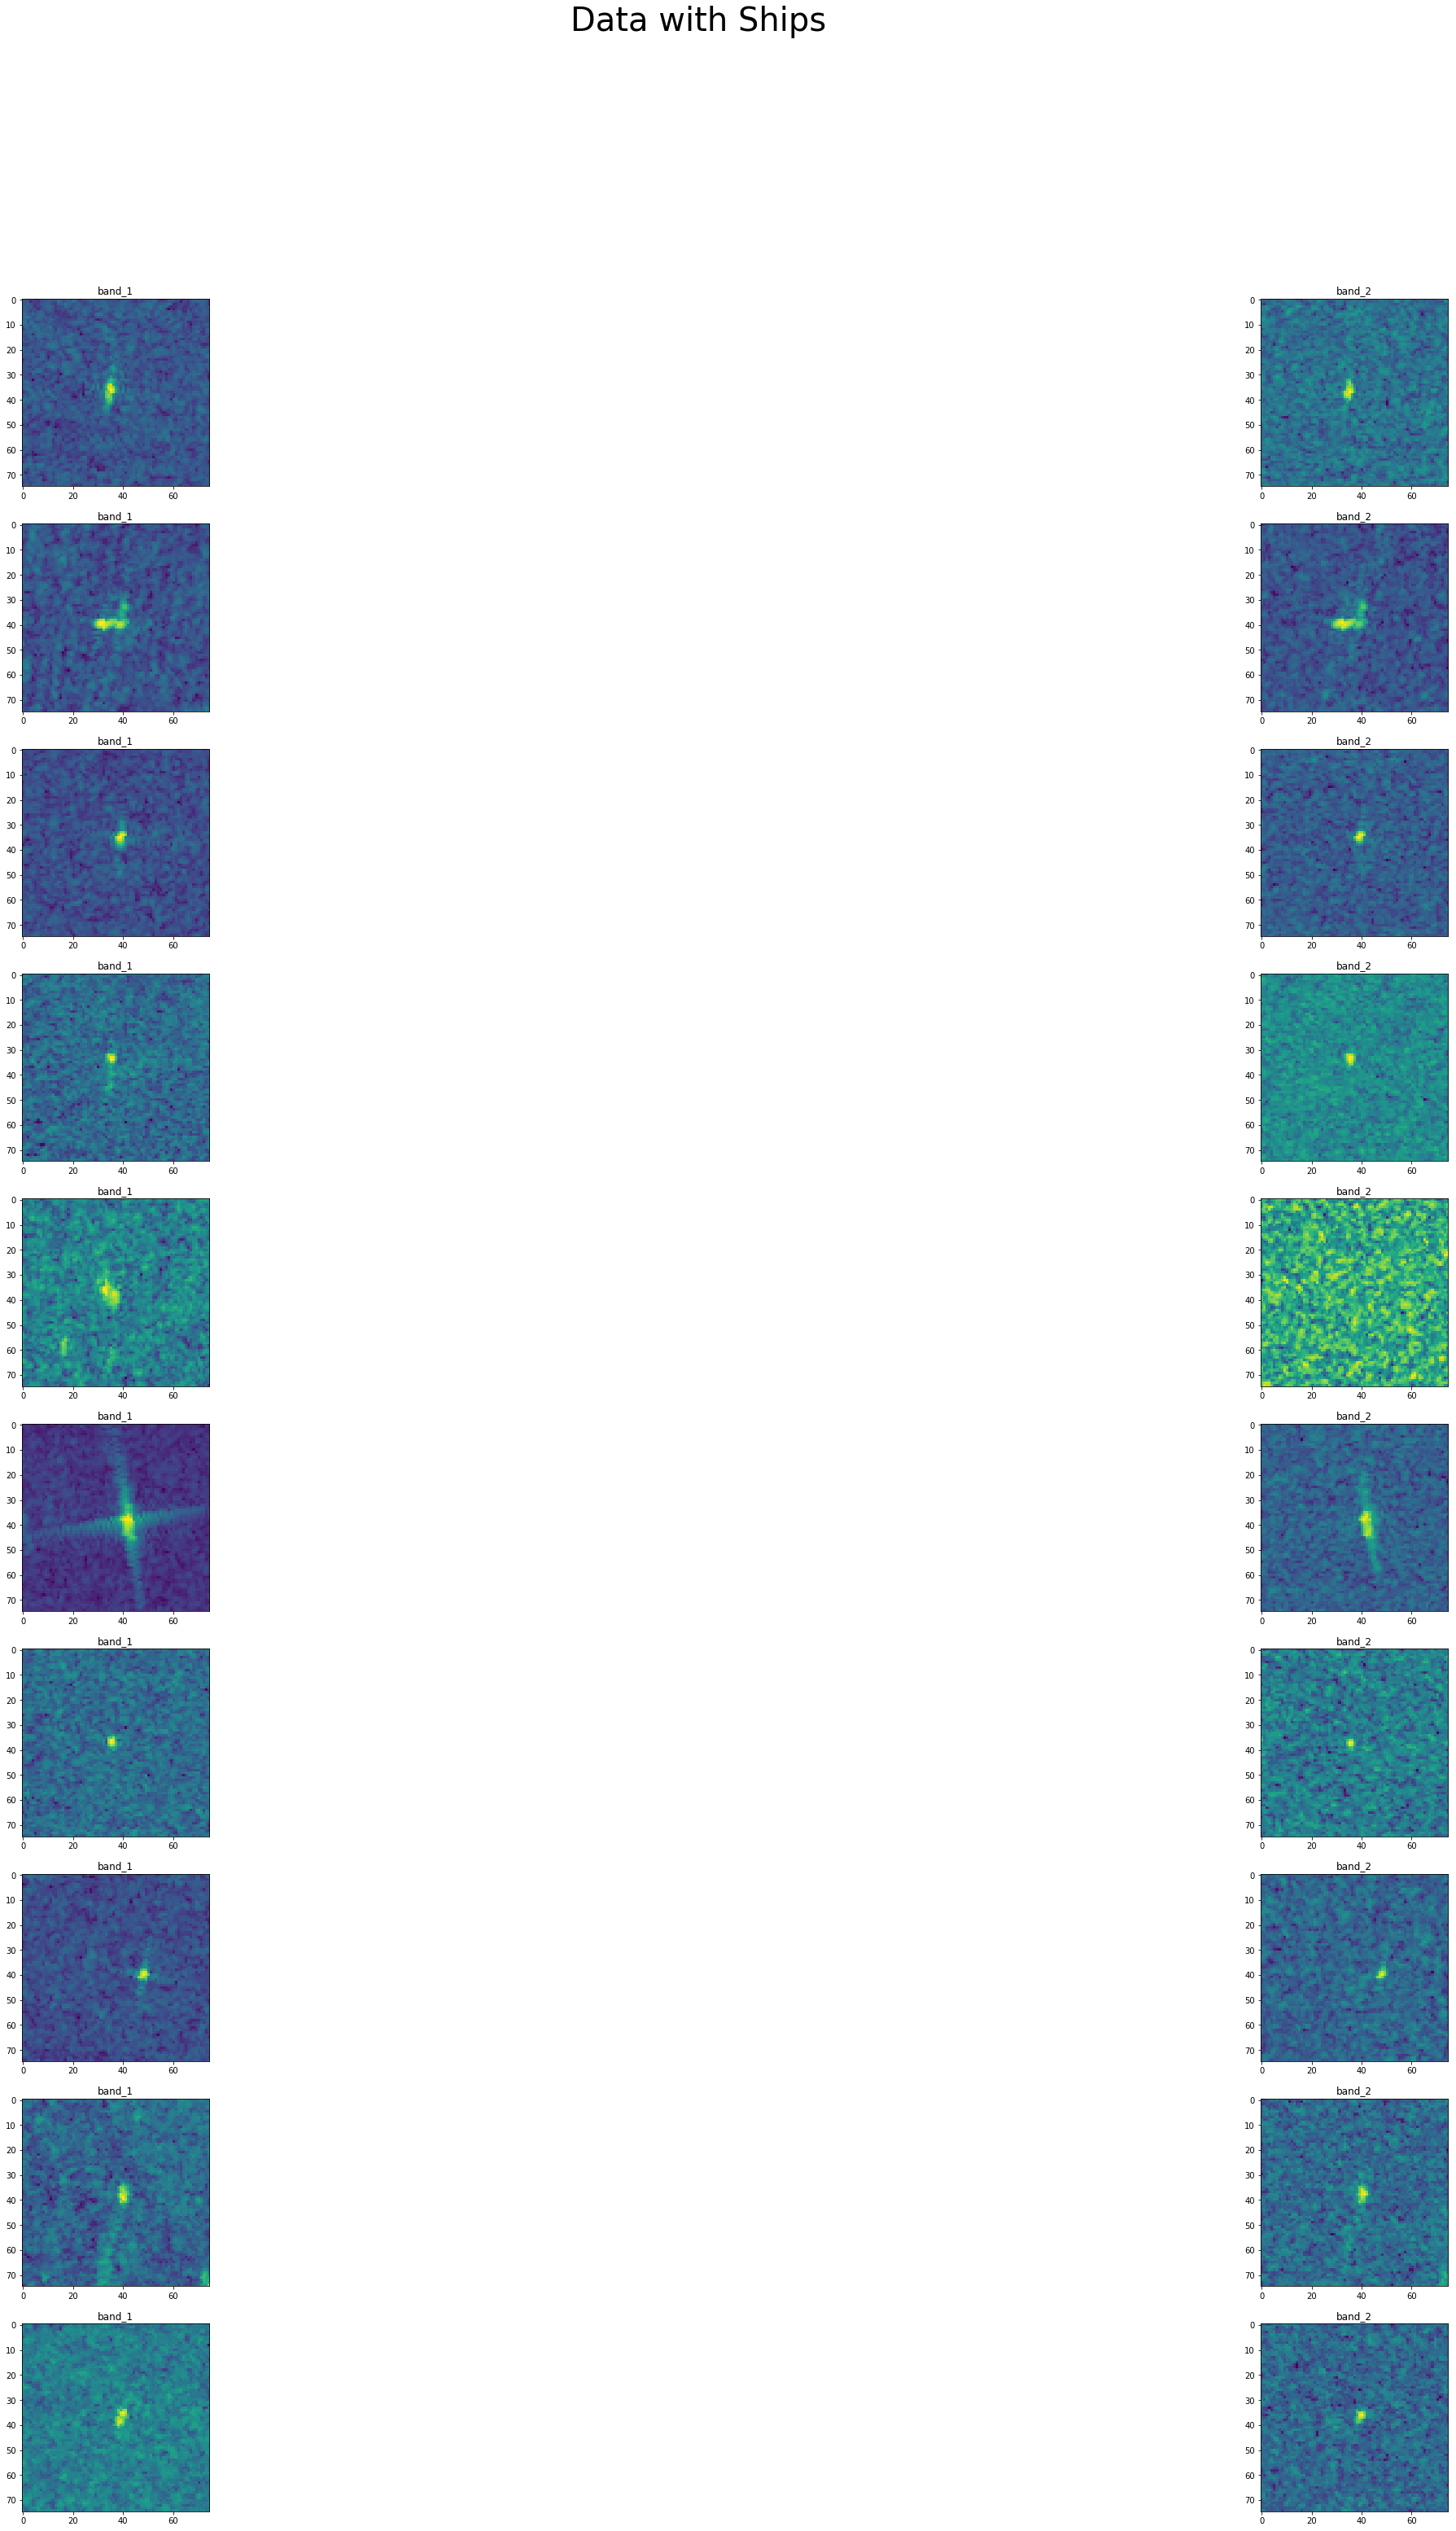

In [17]:
#Visualization of examples of Band_1 band_2 as images

import matplotlib.pyplot as plt
num_show = 10
def plot_images(idx,num,label):
    fig = plt.figure(figsize=(50,50))
    plt.suptitle('Data with '+label, fontsize=40)
    for i in range(num_show):
        plt.subplot(num_show,2,2*i + 1)
        plt.title("band_1")
        img = np.array(train_data[idx].iloc[i]['band_1']).reshape(75,75)
        plt.imshow(img)
    
        plt.subplot(num_show,2,2*i + 2)
        plt.title("band_2")
        img = np.array(train_data[idx].iloc[i]['band_2']).reshape(75,75)
        plt.imshow(img)
    plt.show()
    
# visualization of the first 10 instances classified as iceberg
plot_images(idx_iceberg_td,10,'Iceberg')

# visualization of the first 10 instances classified as Ships
plot_images(idx_ship_td,10,'Ships')

It seems that the iceberg images are more blurry, and the ships images have more strong light pattern.

In [35]:
########################################
## Definition of utils function to create images to tensors


# Definition of pre processing function

def no_process(t):
    return t

def min_max_scaler(t, scale=1):
    tmin = t.min()
    return  scale*(t - tmin) / (t.max() - tmin)


# Definition of 4 functions to create the composite channel with the band1 and band2

def create_band3_1(band1, band2):
    return band1/band2

def create_band3_2(band1, band2):
    return (band1 + band2) /2

def create_band3_3(band1, band2):
    return band1 - band2

def create_band3_4(band1, band2):
    return np.ones(band1.shape)



# Definition of function to create tensor froimage data according pre processing filter

def to_tensor(data, 
              fn_process_band = no_process,
              fn_create_band_3 = create_band3_1):
    """
    Create a tensor of the data
    """
    tensor = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        if fn_create_band_3:
            band_3 = fn_create_band_3(band_1,band_2)
        
        band_1 = fn_process_band(band_1)
        band_2 = fn_process_band(band_2)
        if fn_create_band_3:
            band_3 = fn_process_band(band_3)
        
        if fn_create_band_3:
            t = np.dstack((band_1, band_2, band_3))
        else:
            t = np.dstack((band_1, band_2))
        tensor.append(t)
    return np.array(tensor)



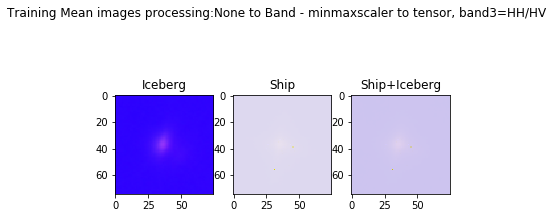

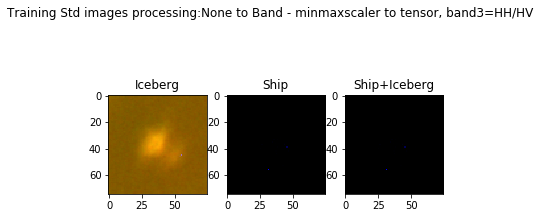

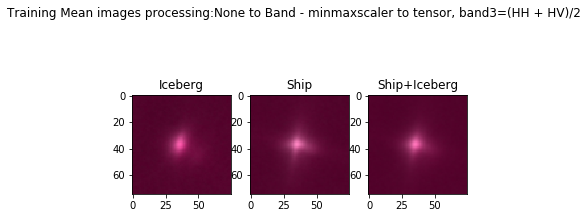

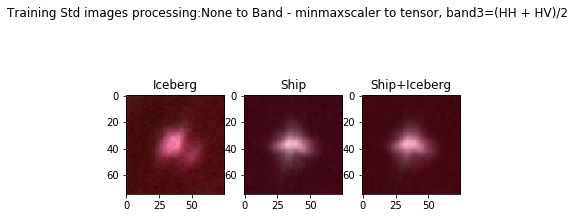

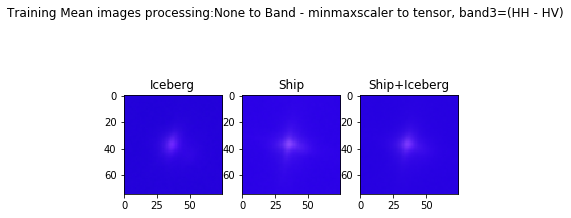

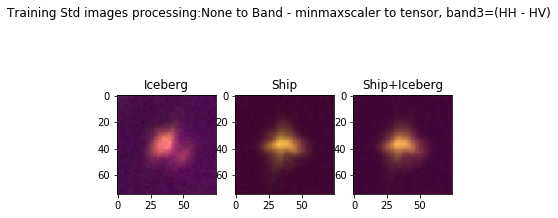

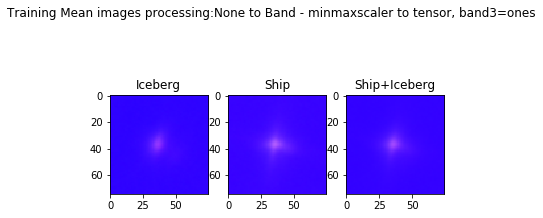

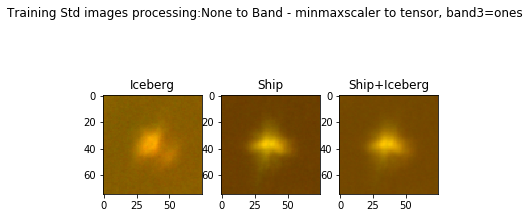

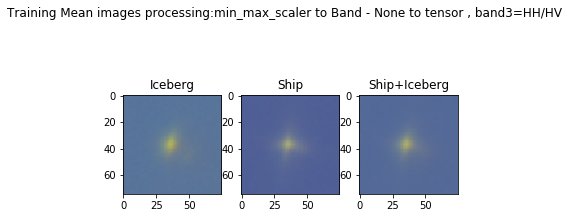

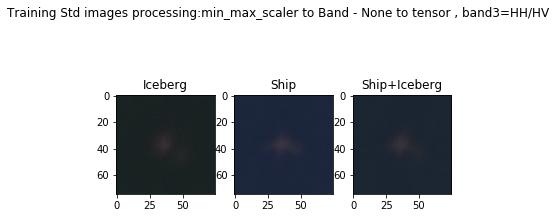

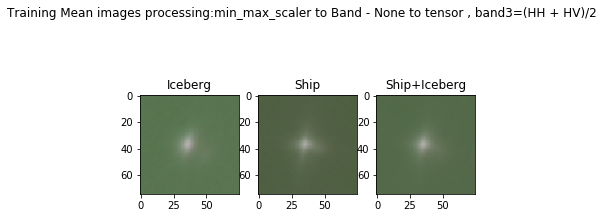

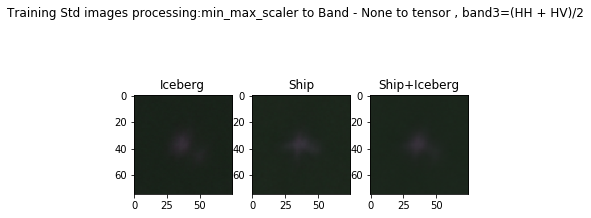

/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


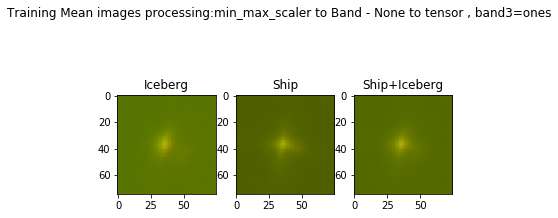

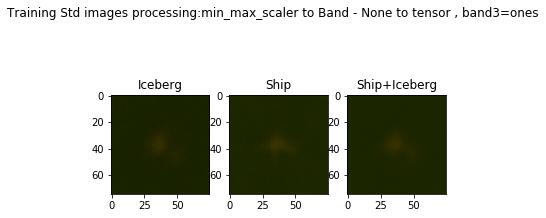

In [40]:
import matplotlib.pyplot as plt
def plot_stat_train_tensor(label_stat,
                     stat,
                     label_process = "None to Band - minmaxscaler to tensor",
                     fn_process_band = no_process,
                     fn_process_tensor = min_max_scaler,
                           
                     label_band3 = "HH/HV",
                     fn_create_band_3 = create_band3_1):
    tensor_data = to_tensor(train_data,
                            fn_process_band = fn_process_band,
                            fn_create_band_3 = fn_create_band_3)
    tensor_iceberg_data = to_tensor(train_data[idx_iceberg_td],
                                    fn_process_band = fn_process_band,
                                    fn_create_band_3 = fn_create_band_3)
    tensor_ship_data = to_tensor(train_data[idx_ship_td],
                                 fn_process_band = fn_process_band,
                                 fn_create_band_3 = fn_create_band_3)

    img_stat_data = stat(tensor_data, axis=0) 
    img_stat_iceberg_data = stat(tensor_iceberg_data,axis=0) 
    img_stat_ship_data = stat(tensor_ship_data,axis=0) 
    
    img_stat_data = fn_process_tensor(img_stat_data)
    img_stat_iceberg_data = fn_process_tensor(img_stat_iceberg_data)
    img_stat_ship_data = fn_process_tensor(img_stat_ship_data)
    
    
    plt.figure()
    plt.suptitle(label_stat+" images processing:"+label_process+', band3='+label_band3)

    plt.subplot(1,3,1)
    plt.title("Iceberg")
    plt.imshow(img_stat_iceberg_data)

    plt.subplot(1,3,2)
    plt.title("Ship")
    plt.imshow(img_stat_ship_data)

    plt.subplot(1,3,3)
    plt.title("Ship+Iceberg")
    plt.imshow(img_stat_data)

    plt.show()


    
#No Process, band3 = HH/HV
#tensor_data = to_tensor(train_data, fn_process_band=no_process, fn_create_band_3=create_band3_1)
#tensor_iceberg_data = to_tensor(train_data[idx_iceberg_td], fn_process_band=no_process, fn_create_band_3=create_band3_1)
#tensor_ship_data = to_tensor(train_data[idx_ship_td], fn_process_band=no_process, fn_create_band_3=create_band3_1)

plot_stat_train_tensor("Training Mean",np.mean)
plot_stat_train_tensor("Training Std",np.std)

#No Process, band3 = (HH + HV)/2
plot_stat_train_tensor("Training Mean",np.mean, label_band3="(HH + HV)/2",fn_create_band_3=create_band3_2)
plot_stat_train_tensor("Training Std",np.std, label_band3="(HH + HV)/2",fn_create_band_3=create_band3_2)


#No Process, band3 = HH - HV
plot_stat_train_tensor("Training Mean",np.mean, label_band3="(HH - HV)", fn_create_band_3=create_band3_3)
plot_stat_train_tensor("Training Std",np.std, label_band3="(HH - HV)",fn_create_band_3=create_band3_3)

#No Process, band3 = ones
plot_stat_train_tensor("Training Mean",np.mean, label_band3="ones", fn_create_band_3=create_band3_4)
plot_stat_train_tensor("Training Std",np.std, label_band3="ones",fn_create_band_3=create_band3_4)



#Min Max Sacler Process, band3 = default
plot_stat_train_tensor("Training Mean",np.mean, 
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process)
plot_stat_train_tensor("Training Std",np.std, 
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process)



#Min Max Sacler Process, band3 = (HH + HV)/2
plot_stat_train_tensor("Training Mean",np.mean, label_band3="(HH + HV)/2",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_2)
plot_stat_train_tensor("Training Std",np.std, 
                       label_band3="(HH + HV)/2",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_2)



#Min Max Sacler Process, band3 = ones
plot_stat_train_tensor("Training Mean",np.mean, label_band3="ones",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_4)
plot_stat_train_tensor("Training Std",np.std, 
                       label_band3="ones",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_4)









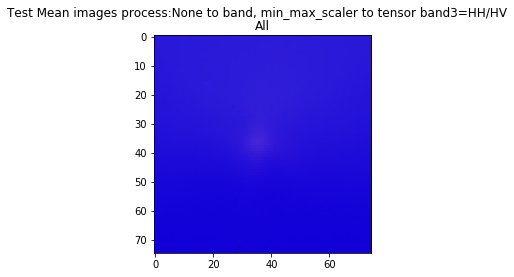

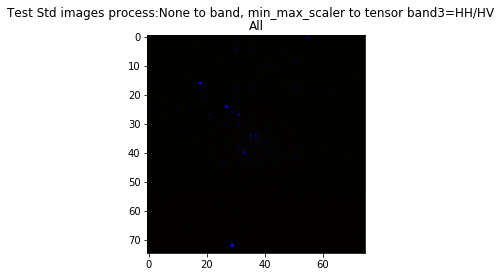

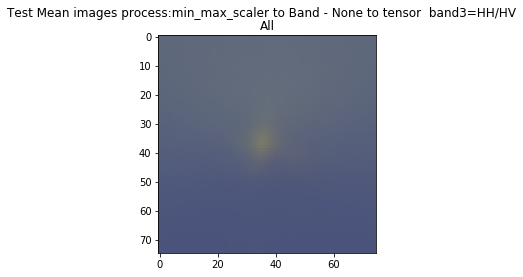

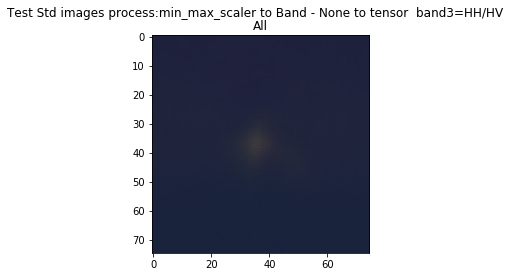

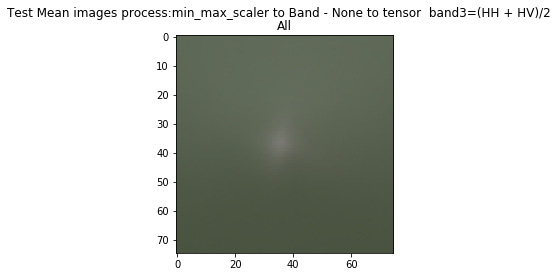

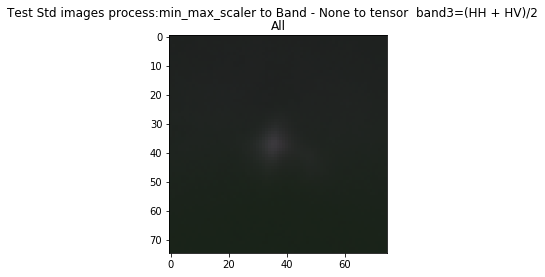

In [41]:

def plot_stat_test_tensor(label_stat,
                     stat,
                     label_process="None to band, min_max_scaler to tensor",
                     fn_process_band = no_process,
                     fn_process_tensor = min_max_scaler,
                     label_band3="HH/HV",
                     fn_create_band_3=create_band3_1):
    tensor_data = to_tensor(test_data, fn_process_band=fn_process_band, fn_create_band_3=fn_create_band_3)
    img_mean_data = stat(tensor_data,axis=0) 
    
    img_mean_data = fn_process_tensor(img_mean_data)
    
    plt.figure()
    plt.suptitle(label_stat+" images process:"+label_process+' band3='+label_band3)

    plt.subplot(1,1,1)
    plt.title("All")
    plt.imshow(img_mean_data)

    plt.show()


plot_stat_test_tensor("Test Mean",np.mean)
plot_stat_test_tensor("Test Std",np.std)


#Min Max Sacler Process, band3 = default
plot_stat_test_tensor("Test Mean",np.mean, 
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process)
plot_stat_test_tensor("Test Std",np.std, 
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process)

plot_stat_test_tensor("Test Mean",np.mean, label_band3="(HH + HV)/2",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_2)
plot_stat_test_tensor("Test Std",np.std, 
                       label_band3="(HH + HV)/2",
                       label_process =  "min_max_scaler to Band - None to tensor ",
                       fn_process_band = min_max_scaler,
                       fn_process_tensor = no_process,
                       fn_create_band_3=create_band3_2)




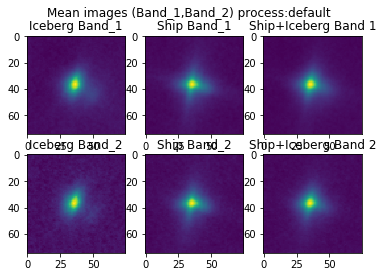

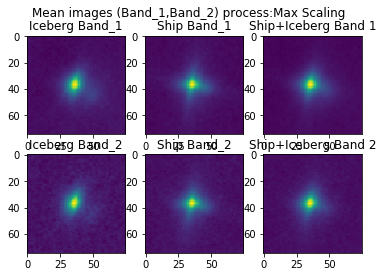

In [11]:
#Plot Mean images for Iceberg and Ship and For Each bands
def extract_band(data,
                 pre_process = no_process):
    tensor_band_1 = []
    tensor_band_2 = []
    
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        
        band_1 = pre_process(band_1)
        band_2 = pre_process(band_2)
        
        
        tensor_band_1.append(band_1)
        tensor_band_2.append(band_2)
        
    return (np.array(tensor_band_1),np.array(tensor_band_2))

def plot_mean_by_band(label_process="default",
                      pre_process = no_process):
    tensor_data = extract_band(train_data, pre_process=pre_process)
    tensor_iceberg_data = extract_band(train_data[idx_iceberg_td], pre_process=pre_process)
    tensor_ship_data = extract_band(train_data[idx_ship_td], pre_process=pre_process)

    img_mean_data_1, img_mean_data_2 = [np.mean(td,axis=0) for td in tensor_data]
    img_mean_iceberg_data_1, img_mean_iceberg_data_2 = [np.mean(td,axis=0) for td in tensor_iceberg_data]
    img_mean_ship_data_1, img_mean_ship_data_2 = [np.mean(td,axis=0) for td in tensor_ship_data]


    plt.figure()
    plt.suptitle("Mean images (Band_1,Band_2) process:"+label_process)

    plt.subplot(2,3,1)
    plt.title("Iceberg Band_1")
    plt.imshow(img_mean_iceberg_data_1)

    plt.subplot(2,3,2)
    plt.title("Ship Band_1")
    plt.imshow(img_mean_ship_data_1)

    plt.subplot(2,3,3)
    plt.title("Ship+Iceberg Band 1")
    plt.imshow(img_mean_data_1)


    plt.subplot(2,3,4)
    plt.title("Iceberg Band_2")
    plt.imshow(img_mean_iceberg_data_2)

    plt.subplot(2,3,5)
    plt.title("Ship Band_2")
    plt.imshow(img_mean_ship_data_2)

    plt.subplot(2,3,6)
    plt.title("Ship+Iceberg Band 2")
    plt.imshow(img_mean_data_2)

    plt.show()
    
plot_mean_by_band()
plot_mean_by_band(label_process='Max Scaling', pre_process= lambda t : min_max_scaler(t,1))

# Learning basic CNN

In [44]:
import mxnet
mxnet.__version__
import keras
print('keras version {}'.format(keras.__version__))

from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend
from keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split


from keras import backend as K
#K.set_image_dim_ordering('th')

keras version 2.1.2


In [46]:
#callbacks
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

def create_standart_callbacks(filepath):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    #lrr = LearningRateScheduler(lr_schedule)
    msave = ModelCheckpoint(filepath, save_best_only=True, save_weights_only=True)
    csv_logger = CSVLogger(filepath+'.csv', append=True, separator=';')
    cs = [msave, csv_logger]
    if backend._BACKEND == 'tensorflow':
        #tb= TensorBoard(log_dir='./logs_tensorboard', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
        pl = PlotLearning()
        cs.append(pl)
    elif backend._BACKEND == 'mxnet':
        pl = PlotLearning()
        cs.append(pl)
    return cs

def sklearn_splitter(tensor_data, target_train):
    return train_test_split(tensor_data, target_train, random_state=seed, train_size=0.80)

def indexes_spliter(tensor_data,target_train,indexes_train,indexes_test):
    return (tensor_data[indexes_train],
            tensor_data[indexes_test], 
            target_train[indexes_train],
            target_train[indexes_test])
            
def indexes_train_test_split(n, random_state, train_size):
        _X, _y, indices = range(n),range(n),range(n)
        _,_,_,_,indices_train, indices_test = train_test_split(_X, _y, indices, random_state=random_state, train_size=train_size)    
        return (indices_train,indices_test)

    

def subplot_hist(hist, idx):
    plt.subplot(idx,2,2*idx)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(idx,2,2*idx + 1)
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

def plot_models(hists):
    fig = plt.figure()
    num_plot = len(hists)
    idx = 1
    for h in hists:
        subplot_hist(h,1)
    plot.show()


class MyModel:
    def __init__(self,
                 name,
                 model,
                 tensor_generator,
                 split_generator,
                 callbacks):
        self.name = name
        self.model = model
        self.tensor_generator = tensor_generator
        self.split_generator = split_generator
        self.callbacks = callbacks
        self.hist = None
    
    def plot_results(self):
        if self.hist:
            plot_models([self.hist])
    def run(self):
        #fit
        print("Preparing data "+self.name)
        tensor_data = self.tensor_generator()
        target_train = train_data['is_iceberg']
        X_train, X_valid, y_train, y_valid = self.split_generator(tensor_data, target_train)
        print(X_train.shape)
        print(X_valid.shape)
        print(y_train.shape)
        print(y_valid.shape)
        #X_train = np.swapaxes(X_train, 1,3)
        #X_valid = np.swapaxes(X_valid, 1,3)
        
        print("Callbacks:"+str(self.callbacks))
        
        print("Fitting "+self.name)
        
        self.hist = self.model.fit(X_train, y_train,
          batch_size=32,
          nb_epoch=40,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=self.callbacks)
        
        print("Clearing "+self.name)
        del X_train
        del X_valid
        del y_train
        del y_valid

idx_train, idx_test = indexes_train_test_split(train_data.shape[0], random_state=seed, train_size=0.80)

/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [47]:
#define our model
def getModel_1(with_compile=True):
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, (3, 3),activation='relu', input_shape=(75, 75,3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    
    #Conv Layer 2
    gmodel.add(Conv2D(128, (3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, (3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, (3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))


    
    if with_compile:
        gmodel.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])
    return gmodel



def get_callback_1(path_weight):
    callbacks = create_standart_callbacks(path_weight)
    callbacks.append(ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5, 
                                   patience=5, 
                                   verbose=1, 
                                   mode='auto', epsilon=0.0001, cooldown=0, min_lr=0))
    return callbacks

    
m1_0 = MyModel("Model 1 - (HH/HV) - minmaxscaler",
             getModel_1(), 
             lambda : to_tensor(train_data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_1),
             lambda train_data,test_data: indexes_spliter(train_data,test_data, idx_train, idx_test),
             get_callback_1("./data/models/model1_band3_1_min_max_scaler_weights.mxnet.hdf5"))
m1_1 = MyModel("Model 1 - (HH+HV)/2 - minmaxscaler",
             getModel_1(), 
             lambda : to_tensor(train_data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_2),
             lambda train_data,test_data: indexes_spliter(train_data,test_data, idx_train, idx_test),
             get_callback_1("./models/model1_band3_2_min_max_scaler_weights.mxnet.hdf5"))
m1_2 = MyModel("Model 1 - (HH-HV) - minmaxscaler",
             getModel_1(), 
             lambda : to_tensor(train_data, fn_process_band=min_max_scaler, fn_create_band_3=create_band3_3),
             lambda train_data,test_data: indexes_spliter(train_data,test_data, idx_train, idx_test),
             get_callback_1("./data/models/model1_band3_3_min_max_scaler_weights.mxnet.hdf5"))

m1_0_b = MyModel("Model 1 - (HH/HV) - no process",
             getModel_1(), 
             lambda : to_tensor(train_data, fn_process_band=no_process, fn_create_band_3=create_band3_1),
             lambda train_data,test_data: indexes_spliter(train_data,test_data, idx_train, idx_test),
             get_callback_1("./data/models/model1_band3_1_no_process_weights.mxnet.hdf5"))
m1_1_b = MyModel("Model 1 - (HH+HV)/2 - no process",
             getModel_1(), 
             lambda : to_tensor(train_data, fn_process_band=no_process, fn_create_band_3=create_band3_2),
             lambda train_data,test_data: indexes_spliter(train_data,test_data, idx_train, idx_test),
             get_callback_1("./data/models/model1_band3_2_no_process_weights.mxnet.hdf5"))
m1_2_b = MyModel("Model 1 - (HH-HV) - no process",
             getModel_1(), 
             lambda : to_tensor(train_data, fn_process_band=no_process, fn_create_band_3=create_band3_3),
             lambda train_data,test_data: indexes_spliter(train_data,test_data, idx_train, idx_test),
             get_callback_1("./data/models/model1_band3_3_no_process_weights.mxnet.hdf5"))

             
models_1 = [m1_0, m1_1, m1_2, m1_0_b, m1_1_b, m1_2_b]
#models_1 = [m1_0, m1_0_b]
#for m in models_1:
#    m.run()

         

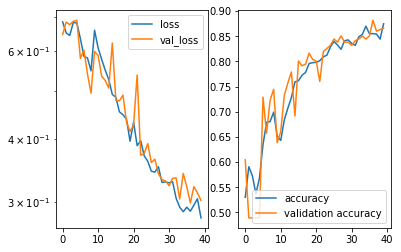

1283/1283 [==============================] - 89s 70ms/step - loss: 0.2786 - acc: 0.8745 - val_loss: 0.3018 - val_acc: 0.8660
Clearing Model 1 - (HH/HV) - minmaxscaler
Preparing data Model 1 - (HH+HV)/2 - minmaxscaler
(1283, 75, 75, 3)
(321, 75, 75, 3)
(1283,)
(321,)
Callbacks:[<keras.callbacks.ModelCheckpoint object at 0x184ddf9e8>, <keras.callbacks.CSVLogger object at 0x184df4828>, <__main__.PlotLearning object at 0x184df4ba8>, <keras.callbacks.ReduceLROnPlateau object at 0x184e0bb70>]
Fitting Model 1 - (HH+HV)/2 - minmaxscaler
Train on 1283 samples, validate on 321 samples


FileNotFoundError: [Errno 2] No such file or directory: './models/model1_band3_2_min_max_scaler_weights.mxnet.hdf5.csv'

In [48]:
#Run all models  1 y 2
for m in models_1:
    m.run()


In [16]:
from keras.models import load_model
def load_my_model(fn, path):
    model = fn(with_compile=False)
    model.load_weights(path)
    return model
    
#m = load_my_model(getModel_1,"./data/models/model1_band3_1_no_process_weights.mxnet.hdf5")
#plot_models([m])




m2 = getModel_1(with_compile=True)
m2.load_weights("./data/models/weights2.hf5")


/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", input_shape=(75, 75, 3...)`
  
/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  app.launch_new_instance()
/Users/bicho/miniconda3/envs/py3_6_keras2/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


In [13]:
from sklearn.model_selection import train_test_split 
def prepareDataMxnet():
    target_train=train_data['is_iceberg']
    X_train, X_valid, y_train, y_valid = train_test_split(rgb_train_data, target_train, random_state=1, train_size=0.80)
    X_train = np.swapaxes(X_train, 1,3)
    X_valid = np.swapaxes(X_valid, 1,3)
    
    return (X_train, X_valid, y_train, y_valid)

In [18]:
file_path_mxnet = ".model_weights2.mxnet.hdf5"
def fitMxnet(gmodel, X_train, X_valid, y_train, y_valid ):
    callbacks = get_callbacksMxnet(filepath=file_path_mxnet, patience=5)

    return gmodel.fit(X_train, y_train,
          batch_size=32,
          nb_epoch=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

from keras.models import load_model

def followfitMxnet(X_train, X_valid, y_train, y_valid):
    model = load_model(file_path_mxnet)
    model.describe()
    callbacks = get_callbacksMxnet(filepath=file_path, patience=5)

    return gmodel.fit(X_train, y_train,
          batch_size=32,
          nb_epoch=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-21 09:29:26.191791. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
gmodel=getModelMxnet()
gmodel.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 73, 73)    1792        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 64, 36, 36)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 64, 36, 36)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 128, 34, 34)   73856       dropout_1[0][0]                  
___________________________________________________________________________________________

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-21 09:29:49.743050. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
(X_train, X_valid, y_train, y_valid) = prepareDataMxnet()
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1283, 3, 75, 75)
(321, 3, 75, 75)
(1283,)
(321,)


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-21 09:29:55.198430. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


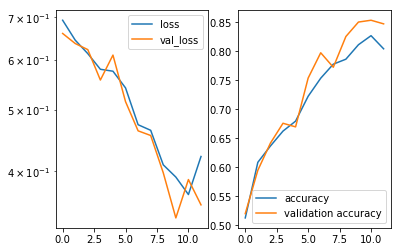

1283/1283 [==============================] - 196s - loss: 0.4223 - acc: 0.8044 - val_loss: 0.3543 - val_acc: 0.8474
Epoch 13/100
  64/1283 [>.............................] - ETA: 125s - loss: 0.5276 - acc: 0.6562

KeyboardInterrupt: 

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 18:38:03.909941. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [199]:
hist = fitMxnet(gmodel, X_train, X_valid, y_train, y_valid)


In [92]:
hist2 = followfitMxnet(X_train, X_valid, y_train, y_valid)

//anaconda/envs/udacity-capstone/lib/python3.5/site-packages/Keras-1.2.2-py3.5.egg/keras/utils/layer_utils.py:37: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(layer_class.from_config)


ValueError: Shape inconsistent: expected () vs got (1,)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 23:41:53.035880. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [67]:
hist

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 22:51:33.587538. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
# import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Learning with pre processing

In [80]:
def pre_process(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)
#mean_img = train_data.mean()
rgb_train_data[:100].shape
rgb_train_data[:100].mean()
np.mean(rgb_train_data[:100])
X_train



NameError: name 'X_train' is not defined

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:30:30.204863. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [209]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split 


target_train=train_data['is_iceberg']
#X_train_valid, X_test, y_train_valid, y_test = train_test_split(rgb_train_data, train_data['is_iceberg'], random_state=1, train_size=0.90)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state=1, train_size=0.80)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(tensor_data, train_data['is_iceberg'], random_state=1, train_size=0.90)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state=1, train_size=0.80)
 

X_train = np.swapaxes(X_train, 1,3)
X_valid = np.swapaxes(X_valid, 1,3)
    
datagen_original = ImageDataGenerator()

datagen_original_test = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             #samplewise_center=False,
                             #samplewise_std_normalization=False,
                             
                             #width_shift_range=0.1,
                             #height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             #rotation_range=45.,
                             #horizontal_flip=True,
                             #vertical_flip=True,
                             #fill_mode='reflect',
                             )
datagen_original_test.fit(X_train)

datagen1 = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             samplewise_center=False,
                             samplewise_std_normalization=False,
                             
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=45.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect',
                             )
datagen2 = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=True,
                             samplewise_std_normalization=True,
                             
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             #zoom_range=0.1,
                             #shear_range=0.1,
                             rotation_range=30.,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect'
                            )

datagen1.fit(X_train)
datagen_original.fit(X_train)



gmodel=getModelMxnet()
gmodel.summary()

file_path_mxnet_preprocess  = ".model_weights_preproces2.mxnet.hdf5"
callbacks = get_callbacksMxnet(filepath=file_path_mxnet_preprocess, patience=5)


#gmodel.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
#                    X_train.shape[0],
#                    100,
#                    validation_data=(X_valid, y_valid),
#                    callbacks=callbacks
#                    )


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_105 (Convolution2D (None, 64, 73, 73)    1792        convolution2d_input_27[0][0]     
____________________________________________________________________________________________________
maxpooling2d_105 (MaxPooling2D)  (None, 64, 36, 36)    0           convolution2d_105[0][0]          
____________________________________________________________________________________________________
dropout_157 (Dropout)            (None, 64, 36, 36)    0           maxpooling2d_105[0][0]           
____________________________________________________________________________________________________
convolution2d_106 (Convolution2D (None, 128, 34, 34)   73856       dropout_157[0][0]                
___________________________________________________________________________________________

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 21:38:26.525326. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [184]:
print(datagen1.mean)
print(datagen_original.mean)



[[[-20.74694633]]

 [[-26.76457405]]

 [[  0.7336846 ]]]
None


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 17:28:33.943835. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [185]:
for e in range(1):
    print('Epoch', e)
    batches = 0
    for batch in datagen_original.flow(X_train,
                 y_train,
                 batch_size=32, 
                 save_to_dir='/Users/bicho/Documents/GitHub/udacity-capstone/data/original',
                                      seed =  seed):
        break
        if batches > 0:
            break
        batches += 1

Epoch 0


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 17:29:20.448915. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [186]:
for e in range(1):
    print('Epoch', e)
    batches = 0
    for batch in datagen1.flow(X_train,
                 y_train,
                 batch_size=32, 
                 save_to_dir='/Users/bicho/Documents/GitHub/udacity-capstone/data/generated',
                 seed =  seed):
        break
        if batches > 0:
            break
        batches += 1
    

Epoch 0


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 17:29:34.941118. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [174]:
help(gmodel.fit_generator)
help(ImageDataGenerator.flow)
help(ImageDataGenerator)


Help on method fit_generator in module keras.models:

fit_generator(generator, samples_per_epoch, nb_epoch, verbose=1, callbacks=None, validation_data=None, nb_val_samples=None, class_weight=None, max_q_size=10, nb_worker=1, pickle_safe=False, initial_epoch=0, **kwargs) method of keras.models.Sequential instance
    Fits the model on data generated batch-by-batch by
    a Python generator.
    The generator is run in parallel to the model, for efficiency.
    For instance, this allows you to do real-time data augmentation
    on images on CPU in parallel to training your model on GPU.
    
    # Arguments
        generator: a generator.
            The output of the generator must be either
            - a tuple (inputs, targets)
            - a tuple (inputs, targets, sample_weights).
            All arrays should contain the same number of samples.
            The generator is expected to loop over its data
            indefinitely. An epoch finishes when `samples_per_epoch`
        

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 17:08:24.564570. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


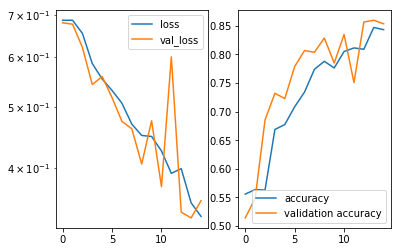

1283/1283 [==============================] - 164s - loss: 0.3346 - acc: 0.8433 - val_loss: 0.3542 - val_acc: 0.8536
Epoch 16/100
1120/1283 [=========================>....] - ETA: 22s - loss: 0.3322 - acc: 0.8393 

KeyboardInterrupt: 

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 20:53:08.571400. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [208]:
gmodel.fit_generator(datagen_original.flow(X_train, y_train, batch_size=32,
                                           #save_to_dir='/Users/bicho/Documents/GitHub/udacity-capstone/data/generated',
                                           #seed =  seed
                                          ),
                    X_train.shape[0],
                    100,
                    validation_data=(X_valid,y_valid),
                    callbacks=callbacks,
                     
                    )

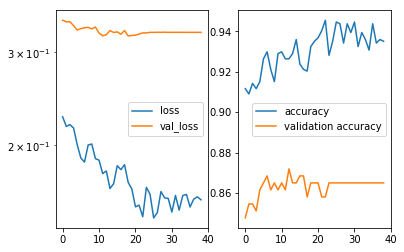

1154/1154 [==============================] - 7357s - loss: 0.1579 - acc: 0.9350 - val_loss: 0.3272 - val_acc: 0.8651
Epoch 40/100
 896/1154 [======================>.......] - ETA: 4181s - loss: 0.1609 - acc: 0.9353 

In [ ]:
gmodel.fit_generator(datagen_original_test.flow(X_train, y_train, batch_size=32,
                                           #save_to_dir='/Users/bicho/Documents/GitHub/udacity-capstone/data/generated',
                                           #seed =  seed
                                          ),
                    X_train.shape[0],
                    100,
                    validation_data=(datagen_original_test.standardize(X_valid),y_valid),
                    callbacks=callbacks,
                     
                    )

In [ ]:
gmodel.fit_generator(datagen_original_test2.flow(X_train, y_train, batch_size=32,
                                           #save_to_dir='/Users/bicho/Documents/GitHub/udacity-capstone/data/generated',
                                           #seed =  seed
                                          ),
                    X_train.shape[0],
                    100,
                    validation_data=(datagen_original_test2.standardize(X_valid),y_valid),
                    callbacks=callbacks,
                     
                    )

In [189]:
datagen1.standardize(X_valid)

array([[[[ -5.55882002e-01,  -1.00698538e+00,  -1.18923402e+00, ...,
           -1.31700181e-01,  -1.66112739e-01,  -1.66112739e-01],
         [ -7.41521631e-01,  -6.46126582e-01,  -6.93142757e-01, ...,
           -4.70408598e-01,  -2.73833755e-01,  -3.49708704e-01],
         [ -1.18925189e+00,  -5.55899872e-01,  -4.29082246e-01, ...,
           -6.46259739e-01,  -6.93275530e-01,  -8.95821882e-01],
         ..., 
         [ -1.80357205e+00,  -1.06618073e+00,  -1.00761466e+00, ...,
           -1.32357608e+00,  -8.43446950e-01,  -7.42266965e-01],
         [ -1.06618073e+00,  -1.06618073e+00,  -8.96318964e-01, ...,
           -9.51168158e-01,  -9.51168158e-01,  -6.93897122e-01],
         [ -4.29703454e-01,  -6.01028983e-01,  -1.32223394e-01, ...,
           -6.55806696e-02,  -9.51176805e-01,  -6.46889977e-01]],

        [[ -9.94674954e-01,  -3.65437781e-01,  -7.24211140e-01, ...,
           -7.24401764e-01,  -5.99157054e-01,  -5.99157054e-01],
         [ -3.65451376e-01,  -5.98978844e-01,

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-20 17:33:09.870402. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Improvement

- Use of Incident angle
- Batch normalization
- Use Data augmentation
- Use spekkle filtering

In [91]:
X_train.shape
X_valid.shape
X_test.shape





(241, 75, 75, 3)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:51:38.819467. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [86]:
X_valid.shape

(321, 3, 75, 75)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:49:56.932755. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [87]:
X_test.shape

(321, 75, 75, 3)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:50:08.651626. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Submission

In [42]:
def predict(data, gmodel, preprocess):
    X_test = preprocess(data)
    return gmodel.predict_proba(X_test)

def create_csv(path, predicted_test):
    result = pd.DataFrame()
    result['id']=test_data['id']
    result['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
    result.to_csv(path, index=False)

In [37]:
test_data[:10]

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874
5,"[-18.13534927368164, -18.13534927368164, -18.1...","[-14.650325775146484, -14.650325775146484, -14...",a8d9b1fd,35.933020
6,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",29e7727e,42.414200
7,"[-20.162964, -18.16898, -17.023144, -17.023216...","[-30.905346, -28.406647, -25.381365, -28.77645...",92a51ffb,33.638300
8,"[-21.920645, -21.737827, -21.383303, -21.73792...","[-25.53537, -28.514198, -27.75848, -31.280354,...",c769ac97,41.107600
9,"[-14.811565, -16.318594, -17.082613, -16.41037...","[-22.617977, -21.065811, -27.914198, -25.24334...",aee0547d,34.966400


In [46]:
X_test = to_tensor(test_data, fn_process_band=no_process, fn_create_band_3=create_band3_2)


In [52]:
X_test.shape

(8424, 75, 75, 3)

In [53]:
predicted_test = m1_0_b.model.predict_proba(X_test)

In [54]:
predicted_test.shape

(8424, 1)

In [55]:
create_csv('res.csv', predicted_test)